In [4]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import os, logging, scipy, re, random
import numpy as np
from scipy.io import wavfile
import scipy.fftpack as fft
from scipy.signal import get_window
from sklearn.model_selection import train_test_split
import IPython.display as ipd
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import soundfile as sf
import librosa, librosa.display
from librosa.feature import zero_crossing_rate, mfcc, spectral_centroid, spectral_rolloff, spectral_bandwidth, chroma_cens, rms
from pathlib import Path
from pydub import AudioSegment, effects  
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.layers import Dense
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, make_scorer
from sklearn.svm import SVC 
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from matplotlib.colors import ListedColormap
from sklearn.metrics import f1_score
from sklearn.pipeline import make_pipeline, Pipeline
import joblib

In [2]:
class FeatureExtraction:
    '''
    Extract important feature
    '''
    RATE = 44100 #44.1kHz
    FRAME = 512 #frame size

    def __init__(self, label=None):
        if label is None:
            self.label =''
        else:
            self.label = label
    
    def feature_extraction(self, data):
        '''
        Using librosa.feature
        Signal will be cut into frames then features are computed for each of these frame and get average of it
        return a Np array which is transformed into a data fram with named columns
        
        '''
        zero_crossing = self.compute_librosa_features(data=data, feature = 'zero_crossing_rate' )
        rmse = self.compute_librosa_features(data=data,feature = 'rmse')
        mfcc = self. compute_librosa_features(data=data, feature='mfcc')
        centroid = self.compute_librosa_features(data=data, feature='centroid')
        rolloff = self.compute_librosa_features(data=data, feature='rolloff')
        bandwidth = self.compute_librosa_features(data=data, feature='bandwidth')
        concat_features = np.concatenate((zero_crossing,
                                          rmse,
                                          mfcc,
                                          centroid,
                                          rolloff,
                                          bandwidth),
                                          axis=0)
        
        logging.info('Processing average...')
        mean_features = np.mean(concat_features, axis=1, keepdims=True).transpose()
        logging.info('Complete')
        return mean_features, self.label

    def compute_librosa_features(self, data, feature):
        '''
        Computing features with librosa
        return a np array
        '''
        logging.info(f'Computing {feature}...')
        if feature == 'zero_crossing_rate':
            return zero_crossing_rate(y=data, hop_length=self.FRAME)
   
        elif feature == 'rmse':
            return rms(y=data, hop_length=self.FRAME)
  
        elif feature == 'mfcc':
            return mfcc(y=audio_data, sr=self.RATE, n_mfcc=13)

        elif feature == 'centroid':
            return spectral_centroid(y=data, sr=self.RATE, hop_length=self.FRAME)

        elif feature == 'rolloff':
            return spectral_rolloff(y=data, sr=self.RATE, hop_length=self.FRAME, roll_percent=0.9)
            
        elif feature == 'bandwidth':
            return spectral_bandwidth(y=data, sr=self.RATE, hop_length=self.FRAME)


In [3]:
from sklearn.preprocessing import normalize

path = './wav_data'
    
dir_list = [x for x in os.listdir(path)]

# initialize empty array for features
# X = np.empty([1, 18])
X = []
# initialise empty array for labels
y = []

logging.info('Creating training set...')
# start = timeit.default_timer()s

# iteration on sub-folders
for directory in dir_list:
    path
    # Instantiate FeatureEngineer'
    feature_extraction = FeatureExtraction(label=directory)

    file_list = os.listdir(os.path.join(path, directory))

    # iteration on audio files in each sub-folder
    
    for audio_file in file_list:
        try:
            # print(f'start: {file_path}')
            file_path = os.path.join(path, directory, audio_file)
            audio_data, sr = librosa.load(file_path, sr=44100, mono=True, duration=3)
            mean_features, label = feature_extraction.feature_extraction(data=audio_data)
            X.append(mean_features)
            y.append(label)
            # print (file_path, len(X), len(y))
            # print('-'*10)
        except:
            print('ERROR')

X = np.array(X)
X = np.squeeze(X)

y = np.array(y)


In [4]:
# scaler = MinMaxScaler()
# X_transform= scaler.fit_transform(X)
le =LabelEncoder()
y = le.fit_transform(y)


In [5]:
clf = make_pipeline(MinMaxScaler(), SVC(C=10, degree=3.0, gamma=1, probability= True))
clf.fit(X, y)

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('svc', SVC(C=10, degree=3.0, gamma=1, probability=True))])

In [16]:
import joblib
joblib.dump(clf, 'svc_final_pipeline.pkl')

['svc_final_pipeline.pkl']

In [14]:
#without labelencoder
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=48, stratify=y)
print(X_train.shape,X_test.shape)

(141, 18) (26, 18)


# Test

In [7]:
def load_model(path):
    model = joblib.load(path)
    return model


def preprocess_input(path):
    audio_data, sr = librosa.load(path, sr=44100, mono=True, duration=3)
    mean_features, label = feature_extraction.feature_extraction(data=audio_data)
    mean_features = np.array(mean_features)
    mf  = np.squeeze(mean_features)

    return mf

## With pipeline

In [10]:
pipeline = load_model('svc_final_pipeline.pkl')

In [20]:
mf = preprocess_input('./wav_data/burp/021.wav')
mf

array([ 1.07971191e-01,  1.97305540e-02, -3.94308432e+02,  1.05403042e+02,
       -7.70554301e+01,  2.55562139e+01, -2.69050747e+01, -8.29293327e-01,
       -3.25571158e+01, -4.05788575e+00,  1.68173069e+01,  9.45616851e-01,
       -1.45664224e+01, -6.24833362e+00, -6.42289876e+00,  3.53480976e+03,
        8.27749786e+03,  3.10422241e+03])

In [27]:
# test = scaler.transform([mf])
prediction = pipeline.predict_proba([mf])
prediction

array([[0.92743968, 0.03167898, 0.00796815, 0.00421648, 0.02869671]])

In [28]:
prediction.argmax()

0

In [35]:
result = {0:'burp', 1:'hungry',2: 'lowerwindpain',3:'tired', 4:'uncomfortable'}
max_pos= prediction.argmax()
for i in result.keys():
    if max_pos == i:
        label = result[i]
        if result [i] == 'burp':
            burp()
        elif result[i] == 'hungry':
            hungry()
        elif result[i] == 'lowerwindpain'
            pain()
        elif result[i] == 'tired'
            tired()
        else:
            discomfort()


burp


In [ ]:
def burp():
    st.write('Burp your baby')
    st.write('Here are some suggestions for how to do it')
    st.image(burp_tech.gif)
    st.image(burp_tech1.gif)

In [ ]:
def hungry():
    st.write('Hungry baby needs milk')
    st.image(milk.png)


In [ ]:
def pain():
    st.write('Hungry baby needs milk')
    st.write('This technique would help')
    st.image(Baby_Massage_Gas.png)

In [ ]:
def tired():
    st.write('Sleepy/ tired baby')
    st.write('A lalluby maybe')
    st.play(Baby_Massage_Gas.png)

## Without pipeline

In [9]:
audio_data, sr = librosa.load('./wav_data/burp/011.wav', sr=44100, mono=True, duration=3)
mean_features, label = feature_extraction.feature_extraction(data=audio_data)
mean_features = np.array(mean_features)
mf  = np.squeeze(mean_features)

In [11]:
mf

array([ 1.07971191e-01,  1.97305540e-02, -3.94308432e+02,  1.05403042e+02,
       -7.70554301e+01,  2.55562139e+01, -2.69050747e+01, -8.29293327e-01,
       -3.25571158e+01, -4.05788575e+00,  1.68173069e+01,  9.45616851e-01,
       -1.45664224e+01, -6.24833362e+00, -6.42289876e+00,  3.53480976e+03,
        8.27749786e+03,  3.10422241e+03])

In [14]:
# test = scaler.transform([mf])
prediction = clf.predict_proba([mf])

In [15]:
prediction

array([[0.92743968, 0.03167898, 0.00796815, 0.00421648, 0.02869671]])

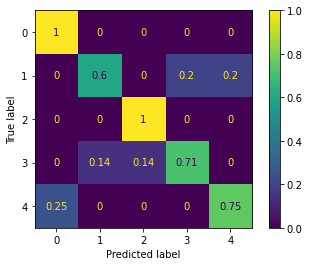

In [22]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

predictions = a.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                      display_labels=clf.classes_)
disp.plot() 

In [17]:
clf.classes_

array([0, 1, 2, 3, 4], dtype=int64)

In [545]:
test.shape

(1, 18)

In [530]:

joblib.dump(pipeline, 'svc.pkl')


['svc.pkl']

In [473]:
def load_model(path):
    model = joblib.load(path)
    return model

pipeline = load_model('svc.pkl')

def preprocess_input(path):
    audio_data, sr = librosa.load(path, sr=44100, mono=True, duration=3)
    mean_features, label = feature_extraction.feature_extraction(data=audio_data)
    mean_features = np.array(mean_features)
    mean_features  = np.squeeze(mean_features)

    return mean_features

In [276]:

# X_val = preprocess_input('recorded.wav')
# a= SVC(C=100, degree=2.0, gamma=0.1, kernel='poly', probability=True).fit(X_train, y_train)

# p = a.predict_proba([X_test[1]])
# pred = pipeline.predict([X_val])
# print(pred)


[0]


In [23]:

audio_data, sr = librosa.load('recorded.wav', sr=44100, mono=True, duration=3)
mean_features, label = feature_extraction.feature_extraction(data=audio_data)
x = np.array(mean_features)
x = np.squeeze(mean_features)


In [536]:
s =SVC(C=10, degree=3.0, gamma=1, probability= True).fit(X_train, y_train)
p = s.predict_proba([x])
p

array([[0.13041504, 0.09515947, 0.14468104, 0.3976276 , 0.23211685]])

In [24]:
# t = preprocess_input('recorded1.wav')
prediction = pipeline.predict_proba([x])
prediction

array([[0.28449751, 0.13468007, 0.07587732, 0.17271417, 0.33223093]])

In [25]:
result = {0:'burp', 1:'hungry',2: 'lowerwindpain',3:'tired', 4:'uncomfortable'}
max_pos= prediction.argmax()

for i in result.keys():
    if max_pos == i:
        label = result[i]
        if result [i] == 'burp':
            print('burp')
        elif result[i] == 'hungry':
            print('hungry')
        elif result[i] == 'lowerwindpain':
            print('lower')
        elif result[i] == 'tired':
            print('tired')
        else:
            print('discomfort')

discomfort


In [437]:
pred.shape

(26,)

In [441]:
import pandas as pd
D = pd.DataFrame(list(zip(class_list, pred[0])))

TypeError: 'numpy.int64' object is not iterable

In [347]:
D

,0,1
0,burp,0.178374
1,hungry,0.107206
2,lowerwindpain,0.163197
3,tired,0.305399
4,uncomfortable,0.245825


In [447]:
def plot_prob(pred,class_list):
    result = dict(zip(class_list, pred))
    clrs = ['cornflowerblue' if (x < np.max(pred)) else 'deeppink'for x in pred ]
    fig = plt.bar(range(len(result)), list(result.values()), color=clrs,align='center')
    plt.xticks(range(len(result)), list(result.keys()))
    st.plotly_chart(fig)


In [448]:
def plot_prob(prediction,class_list):
    pred = prediction[0]
    df = pd.DataFrame(list(zip(class_list, pred)))
    clrs = ['cornflowerblue' if (x < np.max(pred)) else 'deeppink'for x in pred ]
    fig, ax = plt.subplots()
    ax.bar (df[0],df[1],color=clrs,align='center')


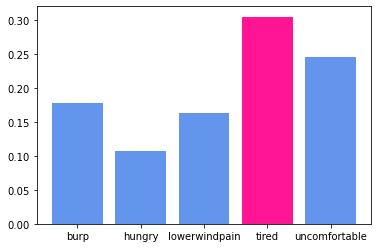

In [449]:
plot_prob(prediction,class_list)

In [450]:
pred = prediction[0]
result = dict(zip(class_list, pred))
result

{'burp': 0.17837380714065185,
 'hungry': 0.10720558844896133,
 'lowerwindpain': 0.16319718966657717,
 'tired': 0.3053987221478988,
 'uncomfortable': 0.24582469259591103}

In [397]:
df = pd.DataFrame(list(zip(class_list, pred)))
df

,0,1
0,burp,0.178374
1,hungry,0.107206
2,lowerwindpain,0.163197
3,tired,0.305399
4,uncomfortable,0.245825
